#### Importing and cleaning data 

In [1]:
# import all libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1)
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb # Needs pip install lightgbm
%matplotlib inline

In [2]:
file_name = "training.csv"
df = pd.read_csv(file_name, index_col='RefId')
print('Percentage of Negative class is {} %'.format(round(df['IsBadBuy'].value_counts()[0]/len(df) * 100,3)))
print('Percentage of Positive class is {} %'.format(round(df['IsBadBuy'].value_counts()[1]/len(df) * 100,3)))

Percentage of Negative class is 87.701 %
Percentage of Positive class is 12.299 %


There is a huge class imbalance, hence accuray is not the correct metrics to evaluate the model. Also, we have to find means to nullify the effect of class imbalance on the model 

In [4]:
df.isnull().sum()

IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentAuctionCleanPrice            315
MMRCurrentR

In [5]:
def find_bad_columns_function(dataframe):
    ''' Returns: 4 lists containing those features that have nulls, blanks, constant values throughout and 
    those features that are duplicate of other features'''
    ###### Finding Null Values
    null_col_list = dataframe.columns[dataframe.isna().any()].tolist()
    print('Identified {} features with atleast one null'.format(len(null_col_list)))

    ###### Finding Blank Spaces in the object column
    # Non-obvious nulls such as blanks: The line items where there are spaces 
    blank_space_col_list = []
    object_columns = dataframe.select_dtypes(include=['object']).columns
    for col in object_columns:
    #   print(col, sum(dataframe[col]==' '))
        if sum(dataframe[col]==' '):
            blank_space_col_list.append(col)
    print('Identified {} features with atleast one blank space'.format(len(blank_space_col_list)))
    
    ####### Finding Quasi Constant/Constant Value in numerical columns
    # Lets remove the variables that have more than 99% of their values as the same 
    # ie their standard deviation is less than 1 %
    
    numeric_df = dataframe._get_numeric_data()
    constant_numeric_col_list = [col for col in numeric_df.columns if numeric_df[col].std()<0.01]
    print('Identified {} numeric features that have quasi-constant values'.format(len(constant_numeric_col_list)))
    
    # We didnt use the following code snippet for the above because if you have closely varying float values
    # then the below wont pick it up
    
    ###### Finding Quasi Constant/Constant non_numeric value
    constant_non_numeric_col_list = []
    # Find the columns that are not in numeric_df
    non_numeric_col_set = set(dataframe.columns) - set(numeric_df.columns)   
    for col in non_numeric_col_set:
        categorical_mode_value = (dataframe[col].mode().values)[0]
        fractional_presence = sum(dataframe[col]==categorical_mode_value)/len(dataframe) 
        if fractional_presence > 0.99:
            constant_non_numeric_col_list.append(col)
            
    print('Identified {} non-numeric features that have quasi-constant values'.format(len(constant_non_numeric_col_list)))
    
    return null_col_list, blank_space_col_list, constant_numeric_col_list, constant_non_numeric_col_list 


In [6]:
null_col_list, blank_space_col_list, constant_numeric_col_list,\
constant_non_numeric_col_list  = find_bad_columns_function(df)

Identified 19 features with atleast one null
Identified 0 features with atleast one blank space
Identified 0 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values


In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
IsBadBuy,1,-0.158886,0.167164,-0.0446196,0.0825604,-0.109252,-0.102954,-0.0874184,-0.0836651,-0.109112,-0.10402,-0.103914,-0.100245,-0.0614884,0.00579642,-0.0999115,-0.0036975,0.0523193
VehYear,-0.158886,1,-0.957957,0.25966,-0.283719,0.581146,0.532927,0.581191,0.53923,0.59082,0.548426,0.59849,0.558669,0.280791,0.0682756,0.349965,0.0573802,-0.268696
VehicleAge,0.167164,-0.957957,1,-0.250801,0.319794,-0.56569,-0.51881,-0.460854,-0.426382,-0.575607,-0.532505,-0.504062,-0.469359,-0.268269,-0.0748569,-0.312329,-0.0247714,0.25931
WheelTypeID,-0.0446196,0.25966,-0.250801,1,-0.213558,-0.0954708,-0.129597,-0.0727003,-0.102019,-0.088597,-0.121211,-0.0744198,-0.102488,0.187199,0.00790108,-0.162826,-0.00674691,-0.132798
VehOdo,0.0825604,-0.283719,0.319794,-0.213558,1,-0.0170218,0.0246171,0.0313058,0.0631649,-0.0285678,0.0121071,0.0158112,0.0480048,-0.288456,-0.0530415,-0.0620085,0.0295558,0.411718
MMRAcquisitionAuctionAveragePrice,-0.109252,0.581146,-0.56569,-0.0954708,-0.0170218,1,0.990347,0.910391,0.910187,0.937817,0.932492,0.871755,0.871042,0.107734,0.0456944,0.78984,0.038818,-0.0504169
MMRAcquisitionAuctionCleanPrice,-0.102954,0.532927,-0.51881,-0.129597,0.0246171,0.990347,1,0.902718,0.918242,0.92361,0.932114,0.860716,0.871203,0.0625025,0.0406752,0.781516,0.0386673,-0.0206443
MMRAcquisitionRetailAveragePrice,-0.0874184,0.581191,-0.460854,-0.0727003,0.0313058,0.910391,0.902718,1,0.990201,0.851647,0.849407,0.913108,0.906054,0.107516,0.0354886,0.746126,0.0806275,-0.053444
MMRAcquisitonRetailCleanPrice,-0.0836651,0.53923,-0.426382,-0.102019,0.0631649,0.910187,0.918242,0.990201,1,0.846914,0.855689,0.903188,0.90681,0.0696759,0.0312839,0.744966,0.0776697,-0.0269328
MMRCurrentAuctionAveragePrice,-0.109112,0.59082,-0.575607,-0.088597,-0.0285678,0.937817,0.92361,0.851647,0.846914,1,0.990329,0.915073,0.912231,0.111363,0.0489654,0.778738,0.0398758,-0.056798


From above we can note that following coloums are corelatted, they appear to be linear combinations 
1. MMRAcquisitionAuctionAveragePrice 
2. MMRAcquisitionAuctionCleanPrice
3. MMRAcquisitionRetailAveragePrice
4. MMRAcquisitonRetailCleanPrice
5. MMRCurrentAuctionAveragePrice
6. MMRCurrentAuctionCleanPrice
7. MMRCurrentRetailAveragePrice
8. MMRCurrentRetailCleanPrice

Except MMRCurrentRetailCleanPrice(which is 0.87) the corelation with MMRAcquisitionAuctionAveragePrice is greated than 0.9. Hence ww will drop all of the above col but MMRAcquisitionAuctionAveragePrice

Further, the Col PRIMEUNIT','AUCGUART had only about 3000 data which in any case is not going to provide significat information and filling these coloumns is going to result in bias in our data 

Lastly, the Col VehYear & VehicleAge, WheelType & WheelTypeID are same hence we can drop one of each 

In [8]:
print(" Shape of original data before: ", df.shape)

df = df.drop(['MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice',
              'MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice',
              ], axis = 1)
print(" Shape of data after dropping correlated cols now is: ", df.shape)


# VehYear and VehicleAge are the same, hence removing the VehYear Col 
# WheelTypeID and WheelType are the same, hence removing WheelType Col

df = df.drop(['VehYear','WheelType'], axis = 1)
print(" Shape of data after dropping VehYear & WheelType set now is: ", df.shape)

# Field "PRIMEUNIT" & "AUCGUART" has only 3419 entry, rest all NULL values, It is as good as not haveing  
# therse fields So we can drop these two coloumns 
df = df.drop(['PRIMEUNIT','AUCGUART'], axis = 1)
print(" Shape of data set after droping PRIMEUNIT & AUCGUART now is: ", df.shape)

 Shape of original data before:  (72983, 33)
 Shape of data after dropping correlated cols now is:  (72983, 27)
 Shape of data after dropping VehYear & WheelType set now is:  (72983, 25)
 Shape of data set after droping PRIMEUNIT & AUCGUART now is:  (72983, 23)


In [9]:
#filling the missing col with mode 
cl = df.columns[df.isna().any()].tolist()
for col in cl:
    df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
df.isnull().sum()

IsBadBuy                             0
PurchDate                            0
Auction                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelTypeID                          0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRCurrentRetailCleanPrice           0
BYRNO                                0
VNZIP1                               0
VNST                                 0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

In [11]:
# This step is needed if you want to convert all categorical columns to ordinal encoded numbers
# Filter the above object columns based on the object data type

object_columns = df.select_dtypes(include=['object']).columns
print(df[object_columns].head(), "\n\n")

# This method of Label Encoding assumes that we are using Tree-based models later.

from sklearn.preprocessing import LabelEncoder

# Iterate through the object columns and convert them one by one into a numerical column
for column in object_columns:
    # Instantiate a labelencoder object and then do the fit transform on the data
    labelencoder = LabelEncoder()
    df[column] = labelencoder.fit_transform(df[column])
    
print(df.head())

       PurchDate Auction   Make                Model Trim           SubModel  \
RefId                                                                          
1      12/7/2009   ADESA  MAZDA               MAZDA3    i         4D SEDAN I   
2      12/7/2009   ADESA  DODGE  1500 RAM PICKUP 2WD   ST  QUAD CAB 4.7L SLT   
3      12/7/2009   ADESA  DODGE           STRATUS V6  SXT   4D SEDAN SXT FFV   
4      12/7/2009   ADESA  DODGE                 NEON  SXT           4D SEDAN   
5      12/7/2009   ADESA   FORD                FOCUS  ZX3       2D COUPE ZX3   

        Color Transmission  Nationality         Size TopThreeAmericanName VNST  
RefId                                                                           
1         RED         AUTO  OTHER ASIAN       MEDIUM                OTHER   FL  
2       WHITE         AUTO     AMERICAN  LARGE TRUCK             CHRYSLER   FL  
3      MAROON         AUTO     AMERICAN       MEDIUM             CHRYSLER   FL  
4      SILVER         AUTO     AME

In [12]:
df.shape

(72983, 23)

In [13]:
Goodbuy = df[df['IsBadBuy']==0]
Badbuy = df[df['IsBadBuy']==1]
print(Goodbuy.shape, Badbuy.shape)

(64007, 23) (8976, 23)


In [14]:
X = df.drop('IsBadBuy', axis=1)
y = df['IsBadBuy']

# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("The length of train:{}| positives in y(train):{}".format(len(X_train), sum(y_train)))
print("The length of test:{}| positives in y(test):{}".format(len(X_test), sum(y_test)))
print('Percentage of Negative class in Train data is {} %'.format(round(y_train.value_counts()[1]/len(y_train) * 100,3)))
print('Percentage of Negative class in Test data is {} %'.format(round(y_test.value_counts()[1]/len(y_test) * 100,3)))

The length of train:58386| positives in y(train):7229
The length of test:14597| positives in y(test):1747
Percentage of Negative class in Train data is 12.381 %
Percentage of Negative class in Test data is 11.968 %


So Far, 
1. Import the data 
2. Deleted the Coloumns that were corealated 
3. Delted Coloums where there was no enough information 
4. Deleted the Col which was duplicate 
5. Filled the missing values by filling with mode 
6. Have done label encoding of all cat col
7. Have Realised that there is a hude imbalance in data 

### UnderSampling

In [16]:
from imblearn.under_sampling import NearMiss
random_state = 42
nm = NearMiss()
X_US,y_US=nm.fit_sample(X_train,y_train)
print(X_US.shape,y_US.shape)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_US)))

(14458, 22) (14458,)
Original dataset shape Counter({0: 64007, 1: 8976})
Resampled dataset shape Counter({0: 7229, 1: 7229})


### OverSampling

##### SMOTETomek 

In [15]:
Goodbuy = df[df['IsBadBuy']==0]
Badbuy = df[df['IsBadBuy']==1]
print(Goodbuy.shape, Badbuy.shape)

(64007, 23) (8976, 23)


In [16]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_SMK,y_SMK=smk.fit_sample(X,y)
print(X_SMK.shape,y_SMK.shape)
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_SMK)))

Using TensorFlow backend.


(126408, 22) (126408,)
Original dataset shape Counter({0: 64007, 1: 8976})
Resampled dataset shape Counter({0: 63204, 1: 63204})


#### Random OverSampling

In [18]:
## RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
ratio = 0.5
os =  RandomOverSampler(ratio)
X_ROS, y_ROS = os.fit_sample(X, y)
X_ROS.shape,y_ROS.shape
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_ROS)))

Original dataset shape Counter({0: 64007, 1: 8976})
Resampled dataset shape Counter({0: 64007, 1: 32003})


### To Use

In [16]:
#X_train1 = X_US
#y_train1 = y_US

In [17]:
X_train1  = X_SMK 
y_train1  = y_SMK

In [18]:
#X_train3 = X_ROS  
#y_train3 = y_ROS  

## week 5 

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
BaggingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from collections import Counter

# store the ratio of negative samples over the total train data points. This will be used to reweight in catboost
rebalance_factor = ((len(y_train1) - sum(y_train1))/sum(y_train1))
# Store the fitted models in a dictionary to be called in a subsequent subroutine
classifier_dict = Counter()

# Catboost doesnt have a balanced param, so I manually entered the rebalance factor
"""
classifier_dict['Cat_Boost'] = CatBoostClassifier(random_state=0, class_weights=[1, rebalance_factor], 
                                boosting_type='Plain', n_estimators=100, bootstrap_type='Bernoulli',
                                               )
"""

classifier_dict['Light_GBM'] = LGBMClassifier(objective='binary', random_state=0, class_weight='balanced')

# Link to a brief comparison among different Gradient Boosting based algorithms 
# https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb
classifier_dict['Decision_Tree'] = DecisionTreeClassifier(random_state=0, class_weight='balanced')
classifier_dict['Bagging_Tree'] = BaggingClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'))
classifier_dict['Random_Forest'] = RandomForestClassifier(random_state=0, class_weight='balanced')
classifier_dict['Extra_Tree'] = ExtraTreesClassifier(random_state=0, class_weight='balanced')
# GBT doesnt have a built-in class rebalancing param
# https://stackoverflow.com/questions/35539937/is-there-class-weight-or-alternative-way-for-gradientboostingclassifier-in-skl
classifier_dict['Gradient_Boosting'] = GradientBoostingClassifier(random_state=0)


In [19]:
#from helper_functions import metrics_store_function, hyper_param_search_function
# Use this to manually store the search space
hyper_param_space_dict = Counter()
"""
hyper_param_space_dict['Cat_Boost'] = {
      'random_state': [0],
      'depth':[6, 3,4,5,7],
      'n_estimators':[100,250],
      'l2_leaf_reg':[3,5,10],
      'min_data_in_leaf': [5,10,25],
      'class_weights':[[1,rebalance_factor],[1,2],[1,3]],
      'verbose':[False],
      'task_type':['GPU'], 
      'bootstrap_type': ['Bernoulli'], 
      'boosting_type': ['Plain']}
"""

# The verbose is set to false just to switch off the logging
# I set the task_type as GPU because I was getting an error due to the min_data_in_leaf param 
# https://github.com/catboost/catboost/issues/939
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
hyper_param_space_dict['Light_GBM'] = {    
    'random_state': [0],
    'max_depth': [3,4,5,6,7], 
    'min_samples_leaf': [5,10,25,50],
    'class_weight': ['balanced',{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}],
    'reg_lambda': [0.01,0.1,1]         }

hyper_param_space_dict['Decision_Tree'] = {
    'random_state': [0],
    'max_depth': [3,4,5,6,7], 
    'min_samples_split': [10,25,50,100],
    'min_samples_leaf': [5,10,25,50],
    'class_weight': ['balanced',{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}]
                                           }
hyper_param_space_dict['Bagging_Tree'] = {
        'random_state': [0],
        'base_estimator__max_depth': [3,4,5,6,7], 
        'base_estimator__min_samples_split': [10,25,50,100],
        'base_estimator__min_samples_leaf': [5,10,25,50],
        'base_estimator__class_weight': ['balanced',{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}]
                                          }
hyper_param_space_dict['Random_Forest'] = {
            'random_state': [0],
            'max_depth': [3,4,5,6,7],
            'min_samples_split': [10,25,50,100],
            'min_samples_leaf': [5,10,25,50],
            'class_weight': ['balanced',{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}]
                                           }
hyper_param_space_dict['Extra_Tree'] = {
            'random_state': [0],
            'max_depth': [3,4,5,6,7],
            'min_samples_split': [10,25,50,100],
            'min_samples_leaf': [5,10,25,50],
            'class_weight': ['balanced',{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}]
                                        }

hyper_param_space_dict['Gradient_Boosting'] = {
    'random_state': [0],
    'min_samples_split': [10,25,50,100],
    'min_samples_leaf': [5,10,25,50]   
                                            }

In [20]:
def metrics_store_function(optimised_model, cv_fold_X_val, cv_fold_y_val):
    
    '''
    Args: The model with the best combo of hyperparams, X & Y validation data
    Logic: After generating the predictions using the passed model, 
    calls the builtin metrics for scoring on the above predictions
    Returns: The Accuracy, Precision, Recall, F1 Score, AUC ROC
    
    '''
    
    from collections import Counter
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    
    classification_metrics_dict = Counter()
    # Predict on the validation folds that have NOT been upsampled
    val_pred = optimised_model.predict(cv_fold_X_val)
    
    classification_metrics_dict['accuracy'] = optimised_model.score(cv_fold_X_val, cv_fold_y_val)
    classification_metrics_dict['precision'] = precision_score(cv_fold_y_val, val_pred)
    classification_metrics_dict['recall'] = recall_score(cv_fold_y_val, val_pred)
    classification_metrics_dict['f1'] = f1_score(cv_fold_y_val, val_pred)
    classification_metrics_dict['roc_auc'] = roc_auc_score(cv_fold_y_val, val_pred)

    return classification_metrics_dict

In [21]:
def hyper_param_search_function(X_train, y_train, hyper_param_space, 
                                classifier_type = RandomForestClassifier(), n_iter = 30,
                                 search_method = 'random_search'):
    '''
    Args: training data + hyperparam search space according to the sklearn classifier being passed;
    
    The search_method specifies whether its a RandomSearchCV or a GridSearchCV being passed inside
    
    '''
    # This is to store the best_params and the roc from each fold 
    hyperparam_results = Counter()

    cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                        test_size=0.2, random_state=42, stratify=y_train)

    # Instantiate a classifier (eg:RandomForest) object along with the hyperparam range
    if search_method == 'random_search':
        search_object = RandomizedSearchCV(classifier_type, 
                                  hyper_param_space, cv = 5, n_iter = n_iter,
                                  verbose=4, random_state=42, n_jobs = 2)

    elif search_method == 'grid_search':
        search_object = GridSearchCV(classifier_type, 
                                  hyper_param_space, cv = 5, 
                                  verbose=4, n_jobs = 2)

    # I have deliberately used the if-else statement because 
    # there are slight syntactical differences between the parameter inputs for Random vs Grid Search

    # Actually fitting the model on the subset of the training data
    model = search_object.fit(cv_fold_X_train, cv_fold_y_train)

    # We really need just 2 sets of data: the best hyperparam combo and validation performance estimate
    hyperparam_results['best_params_'] = model.best_params_
    
    # Get the model with the best combination of hyperparams, use it to predict on validation fold
    optimised_model = model.best_estimator_

    # .... and store all the relevant classification metrics
    classification_metrics_dict = metrics_store_function(optimised_model, cv_fold_X_val, cv_fold_y_val)
    
    hyperparam_results['best_estimator_'] = optimised_model
  
    hyperparam_results['classification_metrics'] = classification_metrics_dict
    
    print('The model with the tuned hyperparams has the following metrics:')

    ######### Pretty print
    print('---' * 45)
    print('')

    print("Accuracy: {}".format(round(classification_metrics_dict['accuracy'],4)))
    print("Precision: {}".format(round(classification_metrics_dict['precision']),4))
    print("Recall: {}".format(round(classification_metrics_dict['recall'],4)))
    print("F1: {}".format(round(classification_metrics_dict['f1'],4)))
    print("AUC ROC: {}".format(round(classification_metrics_dict['roc_auc'],4)))

    print('---' * 45)
    
    return hyperparam_results

In [22]:
%%time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
# You can choose either grid or random search
search_method = 'grid_search'
# Initialize a dictionary to hold the optimum hyperparams
hyperparam_results_dict = Counter()
for classifier_name, classifier_type in classifier_dict.items():
 
    print('Tuning {}'.format(classifier_name))
    # Get the hyperparams that were manually defined
    hyper_param_space = hyper_param_space_dict[classifier_name]
    # Store each of the classifier's hyperparams, optimized model and the classifier's metrics
    hyperparam_results_dict[classifier_name] = hyper_param_search_function(X_train1, y_train1, hyper_param_space, 
                                    classifier_type = classifier_type, search_method = search_method)


Tuning Light_GBM
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   39.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:  8.4min
[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 13.0min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 17.9min
[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed: 23.1min
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed: 27.9min finished


The model with the tuned hyperparams has the following metrics:
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.9005
Precision: 1.0
Recall: 0.8297
F1: 0.8929
AUC ROC: 0.9005
---------------------------------------------------------------------------------------------------------------------------------------
Tuning Decision_Tree
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed:   49.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed:  7.1min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:  9.1min finished


The model with the tuned hyperparams has the following metrics:
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.8035
Precision: 1.0
Recall: 0.7408
F1: 0.7903
AUC ROC: 0.8035
---------------------------------------------------------------------------------------------------------------------------------------
Tuning Bagging_Tree
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   27.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 11.0min
[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 16.4min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 24.4min
[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed: 34.3min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 45.3min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 58.0min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed: 58.7min finished


The model with the tuned hyperparams has the following metrics:
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.8206
Precision: 1.0
Recall: 0.6878
F1: 0.7931
AUC ROC: 0.8206
---------------------------------------------------------------------------------------------------------------------------------------
Tuning Random_Forest
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   44.4s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 19.6min
[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 29.1min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 43.4min
[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed: 61.0min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 79.0min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 100.6min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed: 101.8min finished


The model with the tuned hyperparams has the following metrics:
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.8217
Precision: 1.0
Recall: 0.8162
F1: 0.8207
AUC ROC: 0.8217
---------------------------------------------------------------------------------------------------------------------------------------
Tuning Extra_Tree
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   22.4s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 10.4min
[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 23.0min
[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed: 32.3min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 41.8min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 53.2min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed: 53.9min finished


The model with the tuned hyperparams has the following metrics:
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7597
Precision: 1.0
Recall: 0.7715
F1: 0.7625
AUC ROC: 0.7597
---------------------------------------------------------------------------------------------------------------------------------------
Tuning Gradient_Boosting
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 22.3min finished


The model with the tuned hyperparams has the following metrics:
---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.8561
Precision: 1.0
Recall: 0.7915
F1: 0.8462
AUC ROC: 0.8561
---------------------------------------------------------------------------------------------------------------------------------------
Wall time: 4h 34min 47s


In [23]:
hyper_param_space_dict

Counter({'Light_GBM': {'random_state': [0],
          'max_depth': [3, 4, 5, 6, 7],
          'min_samples_leaf': [5, 10, 25, 50],
          'class_weight': ['balanced',
           {0: 1, 1: 2},
           {0: 1, 1: 3},
           {0: 1, 1: 4},
           {0: 1, 1: 5}],
          'reg_lambda': [0.01, 0.1, 1]},
         'Decision_Tree': {'random_state': [0],
          'max_depth': [3, 4, 5, 6, 7],
          'min_samples_split': [10, 25, 50, 100],
          'min_samples_leaf': [5, 10, 25, 50],
          'class_weight': ['balanced',
           {0: 1, 1: 2},
           {0: 1, 1: 3},
           {0: 1, 1: 4},
           {0: 1, 1: 5}]},
         'Bagging_Tree': {'random_state': [0],
          'base_estimator__max_depth': [3, 4, 5, 6, 7],
          'base_estimator__min_samples_split': [10, 25, 50, 100],
          'base_estimator__min_samples_leaf': [5, 10, 25, 50],
          'base_estimator__class_weight': ['balanced',
           {0: 1, 1: 2},
           {0: 1, 1: 3},
           {0: 1, 1: 4},


In [24]:
hyperparam_results_dict

Counter({'Light_GBM': Counter({'best_params_': {'class_weight': 'balanced',
                   'max_depth': 7,
                   'min_samples_leaf': 5,
                   'random_state': 0,
                   'reg_lambda': 0.01},
                  'best_estimator_': LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                                 colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                                 max_depth=7, min_child_samples=20, min_child_weight=0.001,
                                 min_samples_leaf=5, min_split_gain=0.0, n_estimators=100,
                                 n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
                                 reg_alpha=0.0, reg_lambda=0.01, silent=True, subsample=1.0,
                                 subsample_for_bin=200000, subsample_freq=0),
                  'classification_metrics': Counter({'accuracy': 0.9005221105925164,
                           'precision

In [25]:
# By default, the GridSearchCV has the refit=True which implies that the best_estimator has been retrained on the whole dataset
# https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch

# Create a new dictionary to store the tuned models instantiated below based on the hyperparams above
tuned_classifier_dict = Counter()

for classifier_name, grid_results in hyperparam_results_dict.items():
    
    classifier = grid_results['best_estimator_']
    
    # this is just to stop the logging from being displayed in the output
    if classifier_name == 'Cat_Boost':
        classifier.fit(X_train, y_train, verbose = 0)
        tuned_classifier_dict[classifier_name] = classifier
        
    else:
        classifier.fit(X_train, y_train)
        tuned_classifier_dict[classifier_name] = classifier
    

In [26]:
tuned_classifier_dict

Counter({'Light_GBM': LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                        max_depth=7, min_child_samples=20, min_child_weight=0.001,
                        min_samples_leaf=5, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
                        reg_alpha=0.0, reg_lambda=0.01, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0),
         'Decision_Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                                max_depth=7, max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=5, min_samples_split=50,
                                min_weight_fraction_leaf=0.0, presort='d

In [27]:
def pred_df_gen_function(tuned_classifier_dict, X, classification_threshold=0.5):
    '''
    Args: dictionary containing one or more fitted classifier model which will be used to make predictions against features X
    Returns: a pandas dataframe containing predictions for each of the n classifiers as the first n columns,
    average prediction probabilities and the thresholded prediction
    
    '''
    # Initialize a dictionary to store the prediction probabilities associated with each base learners
    # This dictionary will eventually be converted to a dataframe

    base_learner_pred_probab_dict = Counter()
    
    for clf_name, fitted_base_classifier in tuned_classifier_dict.items():

        # Store the probabilities in a list
        pos_class_prob_list = []

        pos_class_prob_list = [prob_arr[1] 
                               for prob_arr in fitted_base_classifier.predict_proba(X)]

        # Tag the classifier's prediction results against its key in the dictionary
        base_learner_pred_probab_dict[clf_name] = pos_class_prob_list    
    
    # Initialize the dataframe with the above prediction probabilities
    meta_learner_input_X = pd.DataFrame(base_learner_pred_probab_dict)
    
    # Average out each of the base classifier's prediction probabilities and generate a new column 
    meta_learner_input_X['Average Preds'] = meta_learner_input_X.apply(lambda x: np.average(x), axis=1)

    # Create a hard thresholded column for the predicted binary labels
    meta_learner_input_X['yhat'] = meta_learner_input_X['Average Preds'].apply(
                                                        lambda x:1 if x>classification_threshold else 0)

    # Return the dataframe
    return meta_learner_input_X

In [28]:
meta_learner_input_X_test = pred_df_gen_function(tuned_classifier_dict, X_test, classification_threshold=0.5)
meta_learner_input_X_test.head()

,Light_GBM,Decision_Tree,Bagging_Tree,Random_Forest,Extra_Tree,Gradient_Boosting,Average Preds,yhat
0,0.612336,0.667524,0.614018,0.656975,0.580243,0.156584,0.547947,1
1,0.431793,0.779654,0.403815,0.400360,0.393590,0.114193,0.420567,0
2,0.394477,0.571234,0.429876,0.453516,0.495705,0.122739,0.411258,0
3,0.293921,0.571234,0.374779,0.401013,0.464982,0.091793,0.366287,0
4,0.354661,0.333714,0.435732,0.447653,0.499009,0.119947,0.365119,0


In [29]:
from sklearn.metrics import accuracy_score, classification_report, \
roc_curve, roc_auc_score, confusion_matrix

data_type = 'Test'
test_score = accuracy_score(y_test, meta_learner_input_X_test['yhat'])
test_accuracy = float("{0:.2f}".format(test_score.mean()))

print("Has a {} accuracy of {}%".format(data_type, test_accuracy *100))

Has a Test accuracy of 76.0%


In [32]:
labels = ['YES', "NO"]
test_pred = meta_learner_input_X_test['yhat']
print(classification_report(y_test, test_pred, target_names = labels))

              precision    recall  f1-score   support

         YES       0.92      0.81      0.86     12850
          NO       0.24      0.45      0.31      1747

    accuracy                           0.76     14597
   macro avg       0.58      0.63      0.58     14597
weighted avg       0.83      0.76      0.79     14597



In [33]:
y_scores = meta_learner_input_X_test['Average Preds']
roc_auc_val = float("{0:.2f}".format(roc_auc_score(y_test, y_scores)))
print("The ROC AUC score on {} set is {}". format(data_type, roc_auc_val))

The ROC AUC score on Test set is 0.7


In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10346  2504]
 [  959   788]]


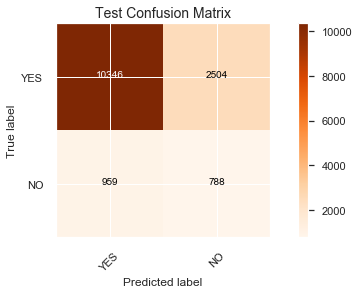

In [35]:
confusion_matrix_test_object = confusion_matrix(y_test, test_pred)
fig = plt.figure(figsize = (8,4))
plot_confusion_matrix(confusion_matrix_test_object, labels,
                               title = data_type+' '+"Confusion Matrix", 
                              cmap = plt.cm.Oranges)